In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

from lxml import etree                            # 安装 lxml ： conda install lxml
from matplotlib.patches import Rectangle
import glob

from PIL import Image

In [2]:
BATCH_SIZE = 16

In [3]:
pil_img = Image.open(r'dataset/images/Abyssinian_1.jpg')

In [4]:
np_img = np.array(pil_img)

In [5]:
np_img.shape

(400, 600, 3)

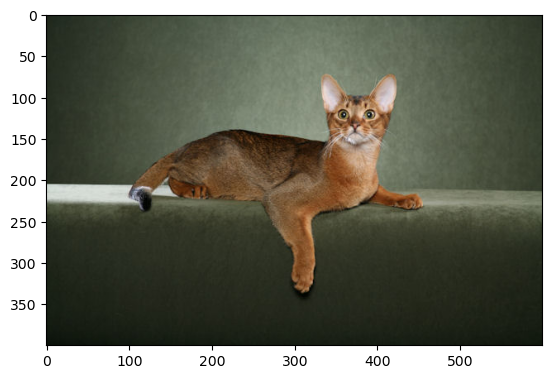

In [6]:
plt.imshow(np_img)
plt.show()

In [7]:
xml = open(r'dataset/annotations/xmls/Abyssinian_1.xml').read()

In [8]:
sel = etree.HTML(xml)

In [9]:
width = sel.xpath('//size/width/text()')[0]
width

'600'

In [10]:
height = sel.xpath('//size/height/text()')[0]
height

'400'

In [11]:
xmin = sel.xpath('//bndbox/xmin/text()')[0]
xmin

'333'

In [12]:
ymin = sel.xpath('//bndbox/ymin/text()')[0]
xmax = sel.xpath('//bndbox/xmax/text()')[0]
ymax = sel.xpath('//bndbox/ymax/text()')[0]

In [13]:
ymin, xmax, ymax

('72', '425', '158')

In [14]:
width = int(width)
height = int(height)

In [15]:
xmin = int(xmin)
ymin = int(ymin)
xmax = int(xmax)
ymax = int(ymax)

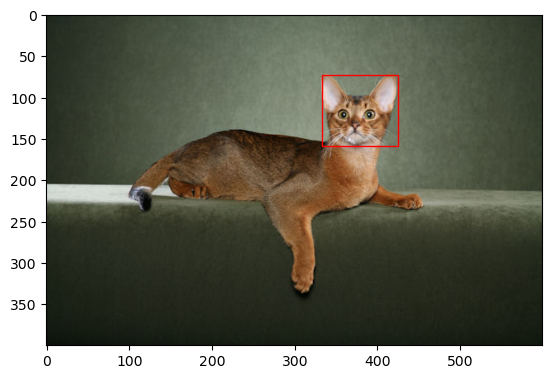

In [16]:
plt.imshow(np_img)
rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
ax = plt.gca()
ax.axes.add_patch(rect)
plt.show()

In [17]:
img = pil_img.resize((224, 224))

In [18]:
xmin = xmin*224/width
ymin = ymin*224/height
xmax = xmax*224/width
ymax = ymax*224/height

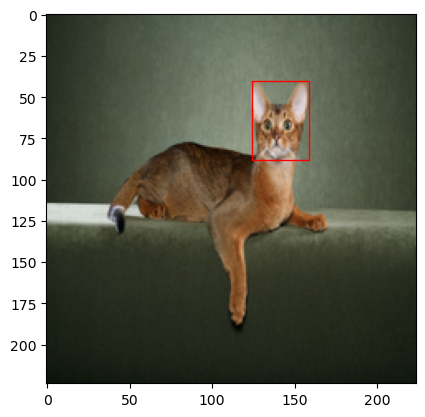

In [19]:
plt.imshow(img)
rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
ax = plt.gca()
ax.axes.add_patch(rect)
plt.show()

# 创建输入

In [20]:
images = glob.glob('dataset/images/*.jpg')

In [21]:
images[:5]

['dataset/images\\Abyssinian_1.jpg',
 'dataset/images\\Abyssinian_10.jpg',
 'dataset/images\\Abyssinian_100.jpg',
 'dataset/images\\Abyssinian_101.jpg',
 'dataset/images\\Abyssinian_102.jpg']

In [22]:
len(images)

7390

In [23]:
xmls = glob.glob('dataset/annotations/xmls/*.xml')

In [24]:
len(xmls)

3686

In [25]:
xmls[:5]

['dataset/annotations/xmls\\Abyssinian_1.xml',
 'dataset/annotations/xmls\\Abyssinian_10.xml',
 'dataset/annotations/xmls\\Abyssinian_100.xml',
 'dataset/annotations/xmls\\Abyssinian_101.xml',
 'dataset/annotations/xmls\\Abyssinian_102.xml']

In [26]:
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]

In [27]:
xmls_names[:3]

['Abyssinian_1', 'Abyssinian_10', 'Abyssinian_100']

In [28]:
len(xmls_names)

3686

In [29]:
imgs = [img for img in images if 
        img.split('\\')[-1].split('.jpg')[0] in xmls_names]

In [30]:
len(imgs)

3686

In [31]:
imgs[:5]

['dataset/images\\Abyssinian_1.jpg',
 'dataset/images\\Abyssinian_10.jpg',
 'dataset/images\\Abyssinian_100.jpg',
 'dataset/images\\Abyssinian_101.jpg',
 'dataset/images\\Abyssinian_102.jpg']

In [32]:
xmls[:5]

['dataset/annotations/xmls\\Abyssinian_1.xml',
 'dataset/annotations/xmls\\Abyssinian_10.xml',
 'dataset/annotations/xmls\\Abyssinian_100.xml',
 'dataset/annotations/xmls\\Abyssinian_101.xml',
 'dataset/annotations/xmls\\Abyssinian_102.xml']

In [33]:
imgs[-5:]

['dataset/images\\yorkshire_terrier_186.jpg',
 'dataset/images\\yorkshire_terrier_187.jpg',
 'dataset/images\\yorkshire_terrier_188.jpg',
 'dataset/images\\yorkshire_terrier_189.jpg',
 'dataset/images\\yorkshire_terrier_190.jpg']

In [34]:
xmls[-5:]

['dataset/annotations/xmls\\yorkshire_terrier_186.xml',
 'dataset/annotations/xmls\\yorkshire_terrier_187.xml',
 'dataset/annotations/xmls\\yorkshire_terrier_188.xml',
 'dataset/annotations/xmls\\yorkshire_terrier_189.xml',
 'dataset/annotations/xmls\\yorkshire_terrier_190.xml']

In [35]:
scal = 224

In [36]:
def to_labels(path):
    xml = open(r'{}'.format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return (xmin/width, ymin/height, xmax/width, ymax/height)

In [37]:
labels = [to_labels(path) for path in xmls]

In [38]:
np.random.seed(2022)
index = np.random.permutation(len(imgs))

In [39]:
images = np.array(imgs)[index]
labels = np.array(labels, np.float32)[index]

In [40]:
sep = int(len(imgs)*0.8)
train_images = images[ :sep]
train_labels = labels[ :sep]
test_images = images[sep: ]
test_labels = labels[sep: ]

In [41]:
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
])

In [42]:
class Oxford_dataset(data.Dataset):
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
        
    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img) 
        pil_img = pil_img.convert("RGB")
        pil_img = transform(pil_img)
        return pil_img, label
    
    def __len__(self):
        return len(self.imgs)

In [43]:
train_dataset = Oxford_dataset(train_images, train_labels, transform)

In [44]:
test_dataset = Oxford_dataset(test_images, test_labels, transform)

In [45]:
train_dl = data.DataLoader(
                      train_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
)

In [46]:
test_dl = data.DataLoader(
                      test_dataset,
                      batch_size=BATCH_SIZE,
)

In [47]:
(imgs_batch, labels_batch) = next(iter(train_dl))

In [48]:
imgs_batch.shape, labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 4]))

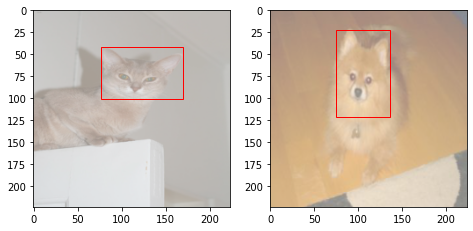

In [49]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[:2], labels_batch[:2])):
    img = (img.permute(1,2,0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    xmin, ymin, xmax, ymax = tuple(label.numpy()*224)
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

# 创建定位模型

In [50]:
resnet = torchvision.models.resnet101(pretrained=True)

In [51]:
in_f = resnet.fc.in_features
print(in_f)

2048


In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(in_f, 4)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [53]:
model = Net()

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [55]:
model = model.to(device)

In [56]:
loss_fn = nn.MSELoss()

In [57]:
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [58]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_loss += loss.item()
    train_loss /= num_batches
    return train_loss

In [59]:
def test(dataloader, model):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

In [60]:
def fit(epochs, train_dl, test_dl, model, loss_fn, optimizer):
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        epoch_loss = train(train_dl, model, loss_fn, optimizer)
        epoch_test_loss = test(test_dl, model)
        train_loss.append(epoch_loss)
        test_loss.append(epoch_test_loss)
        exp_lr_scheduler.step()
        
        template = ("epoch:{:2d}, train_loss: {:.5f}, test_loss: {:.5f}")
        print(template.format(epoch, epoch_loss, epoch_test_loss))
    print("Done!")
    
    return train_loss, test_loss

In [61]:
epochs = 50

In [62]:
train_loss, test_loss = fit(epochs, train_dl, test_dl, model, loss_fn, optimizer)

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 0.02020, test_loss: 0.00720
epoch: 1, train_loss: 0.00376, test_loss: 0.00304
epoch: 2, train_loss: 0.00209, test_loss: 0.00227
epoch: 3, train_loss: 0.00154, test_loss: 0.00191
epoch: 4, train_loss: 0.00105, test_loss: 0.00211
epoch: 5, train_loss: 0.00087, test_loss: 0.00169
epoch: 6, train_loss: 0.00070, test_loss: 0.00177
epoch: 7, train_loss: 0.00037, test_loss: 0.00131
epoch: 8, train_loss: 0.00029, test_loss: 0.00130
epoch: 9, train_loss: 0.00027, test_loss: 0.00130
epoch:10, train_loss: 0.00024, test_loss: 0.00128
epoch:11, train_loss: 0.00022, test_loss: 0.00134
epoch:12, train_loss: 0.00020, test_loss: 0.00124
epoch:13, train_loss: 0.00019, test_loss: 0.00128
epoch:14, train_loss: 0.00016, test_loss: 0.00130
epoch:15, train_loss: 0.00014, test_loss: 0.00128
epoch:16, train_loss: 0.00014, test_loss: 0.00127
epoch:17, train_loss: 0.00013, test_loss: 0.00128
epoch:18, train_loss: 0.00014, test_loss: 0.00128
epoch:19, train_loss: 0.00014, test_loss: 0.00125


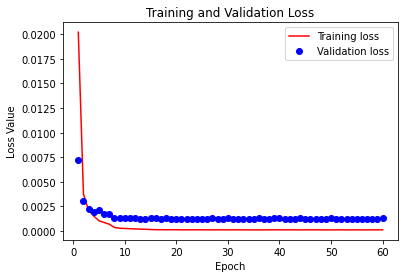

In [63]:
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training loss')
plt.plot(range(1, len(train_loss)+1), test_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# 模型保存

In [64]:
PATH = 'location_model.pth'

In [65]:
torch.save(model.state_dict(), PATH)

In [66]:
model = Net()

In [69]:
model.load_state_dict(torch.load(PATH))
model = model.cpu()

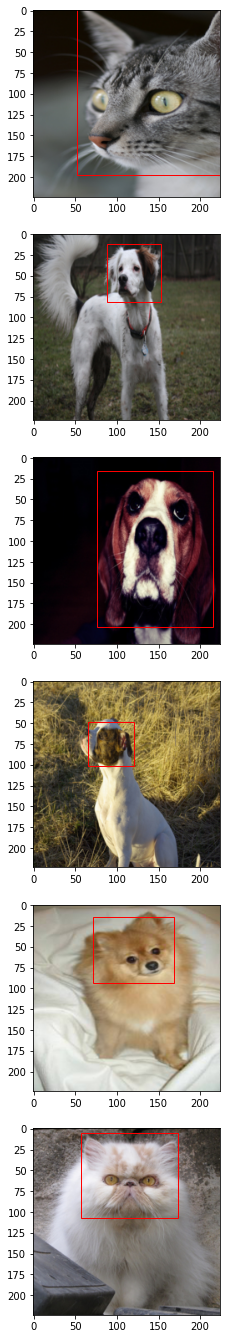

In [70]:
plt.figure(figsize=(8, 24))
imgs, _ = next(iter(test_dl))
out = model(imgs)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.imshow(imgs[i].permute(1,2,0).detach())
    xmin, ymin, xmax, ymax = tuple(out[i].detach().numpy()*224)
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)